# Классификация текстов сверточными нейронными сетями [convolutional neural network]

### Слой свертки

#### Фильтр [filter]:
* $w_{1,n}$ – последовательность слов, $k$  – размер окна
* $w_i$ , $d_{emb}$ – размерность эмбеддинга слова,  $\textbf{w}_i \in \mathbb{R}^{d_{emb}} $
* $\textbf{x}_i = [\textbf{w}_{i}, \textbf{w}_{i+1}, \ldots, \textbf{w}_{i+k-1}]$, $\textbf{x}_i \in \mathbb{R}^{k d_{emb}}$

Фильтр: $p_i = g(\textbf{x}_i  u)$, $p_i \in \mathbb{R}$, $u \in \mathbb{R}^{k d_{emb}}$


![title](img/cnn1.png)


Преобразуем каждое входное окно, но пока размерность входа не уменьшается!

#### Слой субдискретизации (пулинга, [pooling])

* $h_i$ – выходные значения фильтра

$\max$-пулинг:	$c = \max_i h_i$


![title](img/cnn2.png)

* Выбираем самый важный признак из полученных на предыдущем шаге 
* Можем использовать и $\min$, и усреднение



### Классификатор на основе сверточной сети

* $y \in [0,1] $ - истинные значения
* $\widehat{y} = c$ - предсказанные значения

![title](img/cnn3.png)

Для обучения сверточной сети можно использовать обычный алгоритм распространения ошибки

Одномерные фильтры – это сильное ограничение. Что делать, если $c=0.5$?

#### Многомерные фильтры

Используем $\textit{l}$ разных фильтров: $u_{1}, \ldots, u_{\textit{l}}$: 

$\textbf{x}_i = [\textbf{w}_{i}, \textbf{w}_{i+1}, \ldots, \textbf{w}_{i+k-1}]$

$\textbf{p}_i = g(\textbf{x}_i \cdot  U+b)$

$\textbf{p}_i \in \mathbb{R}^{\textit{l}} $, $\textbf{x}_i \in \mathbb{R}^{k d_{emb}}$, $U \in \mathbb{R}^{k d_{emb} \times \textit{l}}$, $b \in \mathbb{R}^{\textit{l}} $

![title](img/cnn4.png)


$\max$-пулинг:	$c_j = \max_i h_{i,j}, j \in [0,\textit{l}]$

#### Шаг окна 
Можно использовать непересекающиеся окна, чтобы уменьшить объем вычисления

![title](img/cnn5.png)

### Как выбирать вектора слов? 
* Случайная инициализация (если нет обученных моделей word2vec, GloVe)
* word2vec, GloVe без обновления
* word2vec, GloVe c обновлением на каждой эпохе (увеличивается количество параметров!)
* Несколько каналов: копируем два входа и
    * на один подаем word2vec и не обновляем эти входы во время обучения, на второй подаем word2vec и обновляем эти входы во время обучения
    * на один вход подаем word2vec, на второй – GloVe

![title](img/cnn6.png)

![title](img/cnn7.png)

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import keras

from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from keras.models import Model, Sequential

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import random
random.seed(1228)

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

%matplotlib inline

from keras.layers import Convolution1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import  concatenate

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from pymystem3 import Mystem
import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

m = Mystem()


regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""



def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


df_neg = pd.read_csv("data/negative.csv", sep=';', header = None, usecols = [3])
df_pos = pd.read_csv("data/positive.csv", sep=';', header = None, usecols = [3])
df_neg['sent'] = 'neg'
df_pos['sent'] = 'pos'
df = pd.concat([df_neg, df_pos])
df.columns = ['text', 'sent']
df.text = df.text.apply(words_only)
df.text = df.text.apply(lemmatize)


X = df.text.tolist()
y = df.sent.tolist()

X, y = np.array(X), np.array(y)

X_text_train, X_text_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 151978
total test examples 74856


In [5]:
df.to_csv('data.csv')

In [6]:
TEXT_LENGTH = 10
VOCABULARY_SIZE = 20000
EMBEDDING_DIM = 100
DIMS = 250
MAX_FEATURES = 5000

batch_size = 32

filter_length = 3

nb_filter = 50

hidden_dims = 100
nb_epoch = 20

### Подготовка данных

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_text_train)
tokenizer

In [8]:
sequences = tokenizer.texts_to_sequences(X_text_train)
X_train = pad_sequences(sequences, maxlen=TEXT_LENGTH)
sequences = tokenizer.texts_to_sequences(X_text_test)
X_test = pad_sequences(sequences, maxlen=TEXT_LENGTH)

In [9]:
X_train[0]

array([ 384,   49, 1983,    4, 6596,  329,  419,    7,  137,  455],
      dtype=int32)

In [10]:
le = LabelEncoder()
le.fit(['pos', 'neg'])
y_train_cat = np_utils.to_categorical(le.transform(y_train), 2)
y_test_cat = np_utils.to_categorical(le.transform(y_test), 2)

print(y_train_cat[0])

[0. 1.]


In [11]:
%%time

import numpy as np
emb_path = '/NLP/embeddings/wiki.ru.vec'

words = []

embeddings_index = {}
f = open(emb_path, encoding = 'utf-8')
for line in f:
    values = line.split()
    if len(values) == 301:
        word = values[0]
        words.append(word)
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

CPU times: user 4min 3s, sys: 35.6 s, total: 4min 39s
Wall time: 9min 23s


In [12]:
print(len(embeddings_index))

1775997


In [13]:
word_index = tokenizer.word_index
len(word_index)

158282

In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [16]:
embedding_matrix.shape

(158283, 300)

In [20]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=TEXT_LENGTH,
                            trainable=False))

model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, input_shape=(MAX_FEATURES,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_cat, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 136780 samples, validate on 15198 samples
Epoch 1/20
136780/136780 [==============================] - 27s 198us/step - loss: 0.5844 - acc: 0.6766 - val_loss: 0.5548 - val_acc: 0.7031
Epoch 2/20
136780/136780 [==============================] - 27s 195us/step - loss: 0.5442 - acc: 0.7112 - val_loss: 0.5337 - val_acc: 0.7159
Epoch 3/20
136780/136780 [==============================] - 26s 191us/step - loss: 0.5220 - acc: 0.7280 - val_loss: 0.5276 - val_acc: 0.7233
Epoch 4/20
136780/136780 [==============================] - 27s 200us/step - loss: 0.5024 - acc: 0.7419 - val_loss: 0.5293 - val_acc: 0.7256
Epoch 5/20
136780/136780 [==============================] - 28s 206us/step - loss: 0.4815 - acc: 0.7565 - val_loss: 0.5307 - val_acc: 0.7260
Epoch 6/20
136780/136780 [==============================] - 28s 202us/step - loss: 0.4606 - acc: 0.7710 - val_loss: 0.5263 - val_acc: 0.7283
Epoch 7/20
136780/136780 [==============================] - 27s 200us/step - loss: 0.4406 - acc: 0.7846

In [21]:
pred = model.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Precision:   0.72
Recall:   0.72
F1-measure:   0.71
Accuracy:   0.72
             precision    recall  f1-score   support

        neg       0.68      0.80      0.73     36884
        pos       0.76      0.64      0.70     37972

avg / total       0.72      0.72      0.71     74856



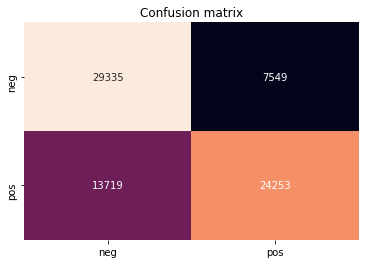

In [22]:
y_pred = pred.argmax(axis=-1)
y_pred = le.inverse_transform(y_pred)

print("Precision: {0:6.2f}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, y_pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))



sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt="d", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion matrix")
plt.show()